In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pickle
import pymc3 as pm
import theano.tensor as tt
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8927
np.random.seed(286)

PARTIES = ["farleft", "left", "green", "center", "right", "farright", "other"]
PARTIES_AGG = [
    "farleft_agg",
    "left_agg",
    "green_agg",
    "center_agg",
    "right_agg",
    "farright_agg",
]

In [2]:
az.style.use("arviz-darkgrid")


def stdz(series: pd.Series) -> pd.Series:
    """Standardize the given pandas Series"""
    return (series - series.mean()) / series.std()

Import election results as well as city-level (`unemployment`) and district-level predictors (`csp_plus` and `pop2554`):

In [3]:
d = pd.read_csv("demo_results_and_preds.csv", index_col=0)
d

arrondissement        date  ville      N  farleft   left  green  center  \
0                 1  2007-04-22  Paris   9152      239   2530    205    2051   
1                 1  2007-06-10  Paris   6825      243      0   1969     818   
2                 1  2008-03-09  Paris   6127       75   2289    439     531   
3                 1  2009-06-07  Paris   5212      275    665   1493     419   
4                 1  2010-03-14  Paris   4843      295   1077   1038     177   
..              ...         ...    ...    ...      ...    ...    ...     ...   
235              20  2014-03-23  Paris  54966     5692  20502   5990       0   
236              20  2014-05-25  Paris  49075     4974  10575   9498    4218   
237              20  2015-12-06  Paris  49130     6100  18315   7348       0   
238              20  2017-04-23  Paris  89574    28512  12469      0   27399   
239              20  2017-06-11  Paris  57413    11546  10700   7766    6505   

     right  farright  other         type  unemployment      csp_plus  \
0     3595       418    114    president           7.8   4886.163367   
1     3430       158    207  legislative           7.8   4886.163367   
2     2641       152      0   municipale           6.6   5042.215106   
3     1808       127    425     european           7.9   5121.184955   
4     1758       261    237     regional           8.2   5126.709956   
..     ...       ...    ...          ...           ...           ...   
235  11467      4112   7203   municipale           8.7  32923.619569   
236   5994      4584   9232     european           8.8  32923.619569   
237   8340      4977   4050     regional           8.7  33664.134135   
238  11451      5305   4438    president           8.0  34330.223246   
239   4300      2446  14150  legislative           8.0  34330.223246   

          pop2554  
0     8915.091416  
1     8915.091416  
2     8845.308159  
3     8967.554268  
4     8886.736184  
..            ...  
235  90139.233180  
236  90139.233180  
237  89863.300140  
238  90336.126337  
239  90336.126337  

[240 rows x 15 columns]

Import poll aggregation for each election (city-level):

In [4]:
aggregated_polls = pd.read_csv("demo_aggregated_polls.csv", index_col=0)
aggregated_polls[PARTIES_AGG] = aggregated_polls[PARTIES_AGG].div(100)

# replace 0 (i.e party not available) by very small values to avoid -inf when taking the log:
aggregated_polls[PARTIES_AGG] = aggregated_polls[PARTIES_AGG].replace(
    to_replace=0, value=aggregated_polls.green_agg.iloc[-2]
)

# revert the softmax:
aggregated_polls[PARTIES_AGG] = aggregated_polls[PARTIES_AGG].apply(np.log) + 1
aggregated_polls.round(2)

type dateelection  samplesize_agg  farleft_agg  left_agg  \
0      president   2007-04-22            1513        -2.63     -0.43   
1   legislatives   2007-06-10             916        -1.61     -0.29   
2     municipale   2008-03-09             755        -2.33      0.19   
3    europeennes   2009-06-07            2287        -1.04     -0.63   
4     regionales   2010-03-14             907        -1.32     -0.24   
5      president   2012-04-22            1400        -0.99     -0.29   
6   legislatives   2012-06-10            1193        -1.53     -0.14   
7     municipale   2014-03-23             977        -1.88      0.04   
8    europeennes   2014-05-25            3248        -1.58     -0.79   
9     regionales   2015-12-06            1749        -1.94     -0.47   
10     president   2017-04-23            1555        -0.67     -1.57   
11  legislatives   2017-06-11            1299        -1.14     -1.53   

    green_agg  center_agg  right_agg  farright_agg  
0       -3.95       -0.67      -0.30         -0.95  
1       -2.30       -1.20       0.12         -1.76  
2       -1.85       -1.51      -0.12         -2.82  
3       -1.01       -1.19      -0.30         -1.85  
4       -1.00       -2.06      -0.24         -1.40  
5       -2.68       -1.27      -0.32         -0.84  
6       -1.98       -2.58      -0.09         -0.88  
7       -1.73      -22.24      -0.01         -1.50  
8       -1.42       -1.33      -0.54         -0.46  
9       -1.84      -22.24      -0.27         -0.24  
10     -22.24       -0.44      -0.64         -0.49  
11      -2.51       -0.19      -0.56         -0.75

Define useful index variables for the model:

In [5]:
district_id, districts = d.arrondissement.factorize(sort=True)
Ndistricts = len(districts)

date_id, dates = d.date.factorize(sort=True)
Ndates = len(dates)

Nparties = len(PARTIES) - 1
N = d.N.values
R_obs = d[PARTIES].values

# which parties are available for choice ("other" always is):
parties_available = pd.concat(
    [
        d[PARTIES].astype(bool).astype(int).iloc[:, :-1],
        pd.Series([1] * len(d), name="other"),
    ],
    axis=1,
).values
parties_available

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 0, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 0, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

Isolate and standardize predictors:

In [50]:
polls = aggregated_polls[PARTIES_AGG].values
city_unemp = stdz(np.log(d.loc[d.arrondissement == 1, "unemployment"])).values[:, None]
district_preds = stdz(np.log(d[["csp_plus", "pop2554"]])).values

In [14]:
city_unemp.shape

(12,)

In [18]:
city_b = np.random.normal(size=(2, Nparties))
city_b

array([[-0.47553503,  0.99118743,  1.98228898, -0.33302997,  1.68131888,
         0.36337073],
       [ 0.00980469,  0.14626039, -1.38683676, -0.72853585,  0.55027339,
         0.59129306]])

In [34]:
(np.array([0, 0, 0, 0, 0, 1]) * polls).round(2)

array([[-0.  , -0.  , -0.  , -0.  , -0.  , -0.95],
       [-0.  , -0.  , -0.  , -0.  ,  0.  , -1.76],
       [-0.  ,  0.  , -0.  , -0.  , -0.  , -2.82],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -1.85],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -1.4 ],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.84],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.88],
       [-0.  ,  0.  , -0.  , -0.  , -0.  , -1.5 ],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.46],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.24],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.49],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.75]])

In [39]:
polls

array([[-2.63351297e+00, -4.32471439e-01, -3.95029188e+00,
        -6.70962786e-01, -2.96017603e-01, -9.46153240e-01],
       [-1.61313595e+00, -2.88538174e-01, -2.29517674e+00,
        -1.19655343e+00,  1.16237644e-01, -1.76364935e+00],
       [-2.32765470e+00,  1.90571912e-01, -1.84913806e+00,
        -1.51348157e+00, -1.16553200e-01, -2.82483387e+00],
       [-1.04064148e+00, -6.28886429e-01, -1.01353888e+00,
        -1.19207447e+00, -2.99654873e-01, -1.85487141e+00],
       [-1.31998126e+00, -2.40300878e-01, -9.96262567e-01,
        -2.06101768e+00, -2.40265560e-01, -1.39870879e+00],
       [-9.88963806e-01, -2.86375157e-01, -2.67706835e+00,
        -1.26591109e+00, -3.17387443e-01, -8.41214500e-01],
       [-1.52900088e+00, -1.35963667e-01, -1.98170825e+00,
        -2.58447923e+00, -8.81934231e-02, -8.80024569e-01],
       [-1.88405544e+00,  3.76566615e-02, -1.72725521e+00,
        -2.22439384e+01, -5.21458208e-03, -1.49633712e+00],
       [-1.58278826e+00, -7.90411042e-01, -1.420

In [27]:
city_preds = np.asarray([np.vstack((city_unemp, polls[:, p_id])) for p_id in range(Nparties)])
city_preds.shape

(6, 2, 12)

In [48]:
city_b[0] * city_unemp[:, None] + city_b[1] * polls

(12, 6)

In [43]:
(np.array([0, 0, 0, 0, 0, 1]) * city_unemp[:, None]).round(2)

array([[-0.  , -0.  , -0.  , -0.  , -0.  , -0.47],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.47],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -2.63],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.3 ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.18],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.49],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.49],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.95],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.09],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.95],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.14],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.14]])

In [46]:
city_unemp.round(2)

array([-0.47, -0.47, -2.63, -0.3 ,  0.18,  0.49,  0.49,  0.95,  1.09,
        0.95, -0.14, -0.14])

Define and run the model:

(12, 6)
(12, 6)
(12, 6)
(20, 12, 6)
(240, 6)


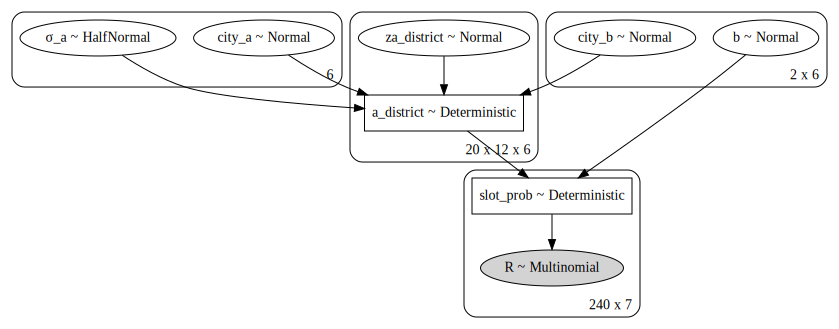

In [51]:
with pm.Model() as m_h_intercept_polls:
    city_a = pm.Normal("city_a", mu=-1.8, sigma=1.0, shape=Nparties)
    city_b = pm.Normal("city_b", mu=0.0, sigma=0.1, shape=(2, Nparties))
    σ_a = pm.HalfNormal("σ_a", 1.0, shape=Nparties)
    
    print((city_b[0] * city_unemp).tag.test_value.shape)
    print((city_b[1] * polls).tag.test_value.shape)
    a = city_a + city_b[0] * city_unemp + city_b[1] * polls
    print(a.tag.test_value.shape)
    za_district = pm.Normal(f"za_district", 0.0, 1.0, shape=(Ndistricts, Ndates, Nparties))
    a_district = pm.Deterministic(f"a_district", a + za_district * σ_a)
    print(a_district.tag.test_value.shape)
    b = pm.Normal("b", 0.0, 0.1, shape=(2, Nparties))
    
    # expected value per district:
    mu = a_district[district_id, date_id] + pm.math.dot(district_preds, b)
    print(mu.tag.test_value.shape)

    # append last category:
    vary_pivot = tt.as_tensor_variable(
        np.full(shape=(Ndistricts, Ndates, 1), fill_value=-2.2)
    )
    mu = tt.horizontal_stack(mu, vary_pivot[district_id, date_id])
    
    # preferences of each district, for all elections:
    latent_p = parties_available * mu
    # zero-inflation process:
    # keep only preferences for available parties:
    slot_prob = pm.Deterministic("slot_prob", tt.nnet.softmax(latent_p))
    
    R = pm.Multinomial("R", n=N, p=slot_prob, observed=R_obs)

pm.model_to_graphviz(m_h_intercept_polls)

In [11]:
with m_h_intercept_polls:
    m_h_intercept_polls_trace = pm.sample(
        1000, tune=2000, random_seed=RANDOM_SEED
    )
az.summary(m_h_intercept_polls_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_farright, a_district_farright, city_b_farright, city_a_farright, b_right, a_district_right, city_b_right, city_a_right, b_center, a_district_center, city_b_center, city_a_center, b_green, a_district_green, city_b_green, city_a_green, b_left, a_district_left, city_b_left, city_a_left, b_farleft, a_district_farleft, city_b_farleft, city_a_farleft]


The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  \
city_a_farleft          -1.16  0.13   -1.40    -0.90       0.00     0.00   
city_b_farleft[0]       -0.12  0.06   -0.23    -0.01       0.00     0.00   
city_b_farleft[1]        0.15  0.08    0.01     0.29       0.00     0.00   
a_district_farleft[0,0] -1.39  0.16   -1.67    -1.09       0.01     0.01   
a_district_farleft[0,1]  0.30  0.14    0.05     0.57       0.01     0.01   
...                       ...   ...     ...      ...        ...      ...   
slot_prob[239,2]         0.14  0.00    0.13     0.14       0.00     0.00   
slot_prob[239,3]         0.11  0.00    0.11     0.12       0.00     0.00   
slot_prob[239,4]         0.07  0.00    0.07     0.08       0.00     0.00   
slot_prob[239,5]         0.04  0.00    0.04     0.04       0.00     0.00   
slot_prob[239,6]         0.25  0.00    0.24     0.25       0.00     0.00   

                         ess_mean   ess_sd  ess_bulk  ess_tail  r_hat  
city_a_farleft            6783.88  6647.15   6779.52   2877.93    1.0  
city_b_farleft[0]         5527.67  4520.56   5513.55   3310.99    1.0  
city_b_farleft[1]         6226.96  4822.64   6159.30   2903.09    1.0  
a_district_farleft[0,0]    336.36   336.36    336.43    828.80    1.0  
a_district_farleft[0,1]    275.09   275.09    275.10    845.71    1.0  
...                           ...      ...       ...       ...    ...  
slot_prob[239,2]          3917.46  3917.46   3921.55   3372.63    1.0  
slot_prob[239,3]          4113.46  4108.70   4123.43   3412.07    1.0  
slot_prob[239,4]          3853.12  3853.12   3845.17   3273.36    1.0  
slot_prob[239,5]          4250.09  4250.09   4250.28   3634.94    1.0  
slot_prob[239,6]          4384.00  4383.04   4384.90   3405.17    1.0  

[3150 rows x 11 columns]

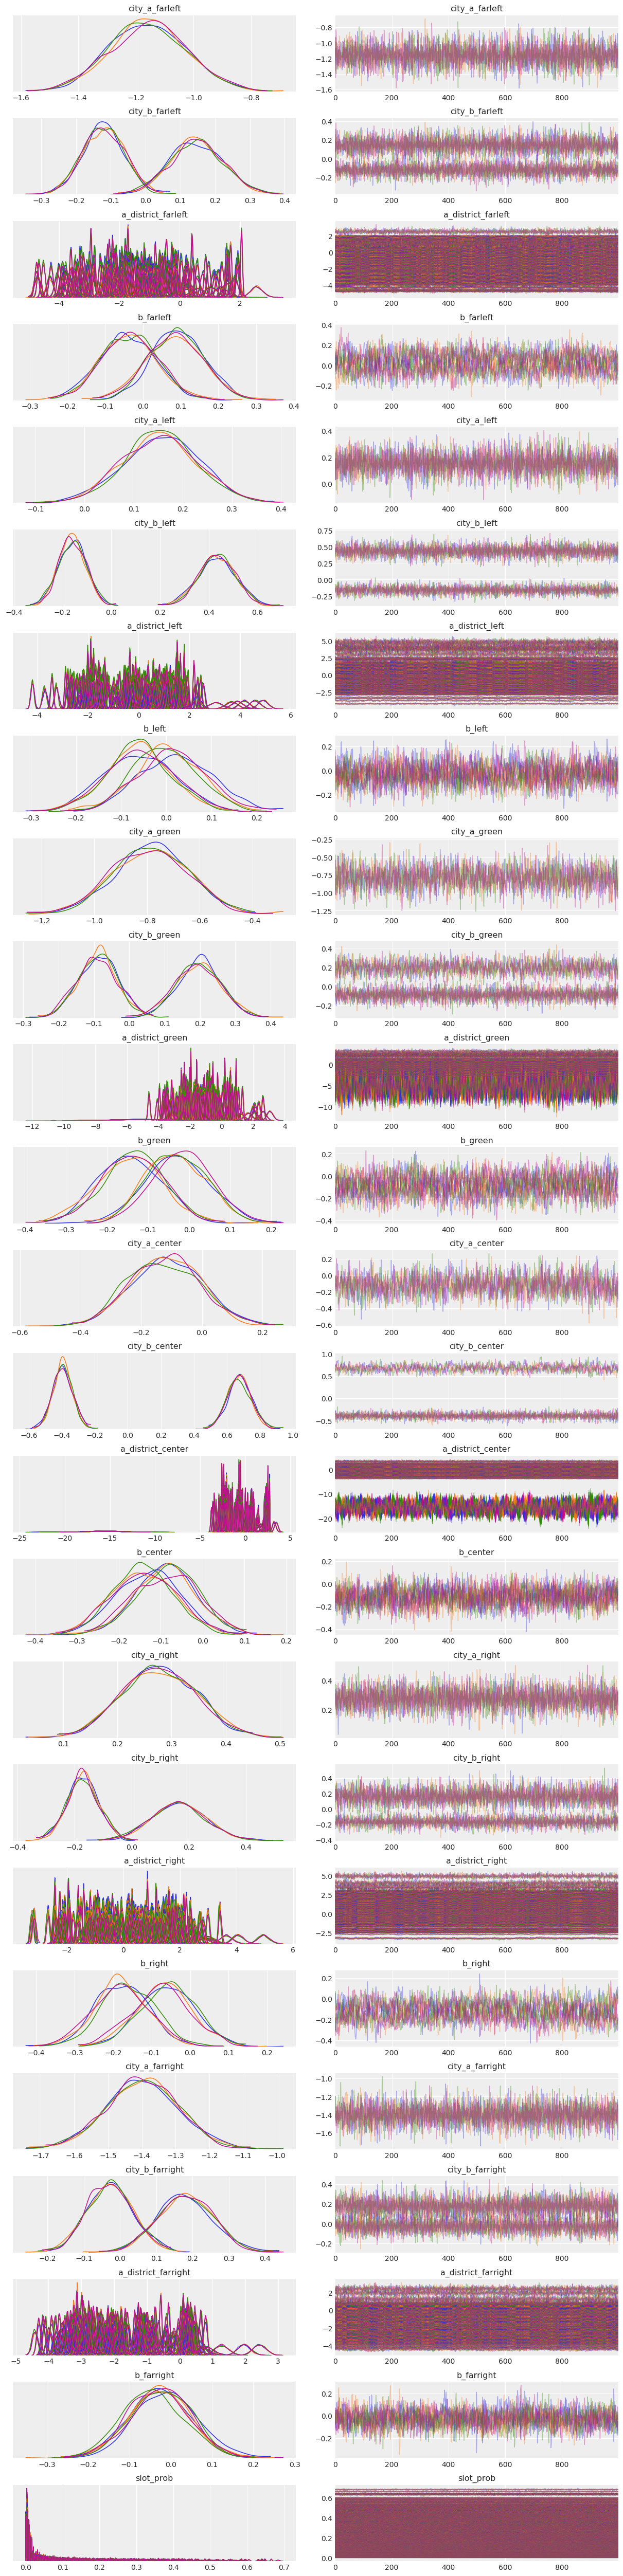

In [12]:
az.plot_trace(m_h_intercept_polls_trace, compact=True);

In [8]:
# DO NOT RUN
%watermark -a AlexAndorra -n -u -v -iv

numpy  1.17.3
pandas 0.25.3
pymc3  3.8
arviz  0.6.1
AlexAndorra 
last updated: Thu Jan 30 2020 

CPython 3.7.5
IPython 7.9.0
